In [1]:
import warnings, uproot, optuna, time, json, math
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, log_loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class json_info:
    def __init__(self, config):
        with open(config, 'r') as file:
            json_file = json.load(file)
        self.training_variables = json_file["training_variables"]
        self.xgb_fixed_param = {}
        for d in json_file["xgb_fixed_param"]:
            self.xgb_fixed_param.update(d)
        self.xgb_scanned_param = {}
        for d in json_file["xgb_scanned_param"]:
            self.xgb_scanned_param.update(d)
        self.Sel_bkg = json_file["Sel_bkg"]
        self.Sel_sig = json_file["Sel_sig"]
        self.tree_name = json_file["tree_name"]
        self.data_path = json_file["data_path"]
        self.output_folder = json_file["output_folder"]
        self.test_size = json_file["test_size"]
        self.optuna_options = {}
        for d in json_file["optuna_options"]:
            self.optuna_options.update(d)
        try:
            self.weight_column = [json_file['weight_column']]
        except KeyError:
            self.weight_column = None
        try:
            self.out_label = [json_file['out_label']]
        except KeyError:
            self.label = None

    def __str__(self):
        out = f"BDT hyperparameters scan \nFile: {self.data_path} \nTree: {self.tree_name} \nSignal: {self.Sel_sig} \nBackground: {self.Sel_bkg}"
        return out
    
    def get_input_features(self, df, branch_list, cuts=''):
        if cuts=='': return df[branch_list]
        _df = df[df.eval(cuts)]
        _df = _df.reset_index(drop=True)
        return _df[branch_list]
    
    def load_data(self):
        print("Loading data from", self.data_path)
        f = uproot.open(self.data_path)
        tree = f[self.tree_name]
        self.data = tree.arrays(library="pd")
        if self.weight_column is not None:
            variables = self.training_variables + self.weight_column
        else:
            variables = self.training_variables
        label = "_label"
        while "_label" in variables:
            label = label + "_"
        self.label = label
        
        sig_data = self.get_input_features(self.data, variables, self.Sel_sig)
        sig_data[label] = 1
                
        bkg_data = self.get_input_features(self.data, variables, self.Sel_bkg)
        bkg_data[label] = 0
        
        self.data = pd.concat([bkg_data, sig_data])
    
    def train_test_splitting(self):
        if self.weight_column is not None:
            variables = self.training_variables + self.weight_column
        else:
            variables = self.training_variables
        X = self.data[variables]
        y = self.data[self.label]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=42, stratify=y)
        if self.weight_column is not None:
            self.W_train = X_train[self.weight_column]
            self.W_test = X_test[self.weight_column]
            self.X_train = X_train[self.training_variables]
            self.X_test = X_test[self.training_variables]
        else:
            self.X_train = X_train
            self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


In [3]:
settings = json_info("config_best.json")
settings.load_data()
settings.train_test_splitting()

Loading data from /lustrehome/mbuonsante/Tau_3mu/CC_etc/CMSSW_13_0_13/src/ROOTFiles/AllData2022.root


In [4]:
print(settings.training_variables)

['cLP', 'tKink', 'segmComp', 'fv_nC', 'fv_dphi3D', 'fv_d3Dsig', 'fv_d3D', 'mindca_iso', 'trkRel', 'd0sig', 'Ptmu3', 'd0sig_max', 'MVASoft1', 'MVASoft2', 'MVASoft3', 'Pt_tripl']


In [5]:
parameters = []
features = []
auc_score_testV = []
auc_score_trainV = []
def objective(trial):
    """Define the objective function"""
    var_params = {key: trial.suggest_discrete_uniform(key, settings.xgb_scanned_param[key][0], settings.xgb_scanned_param[key][1], settings.xgb_scanned_param[key][2]) for key in settings.xgb_scanned_param.keys()}

    integer_options = ['n_estimators', 'num_boost_round', 'max_depth']
    
    for key in settings.xgb_scanned_param.keys():
        if key in integer_options:
            var_params[key] = int(var_params[key])
            
    params = {**settings.xgb_fixed_param, **var_params}

    parameters.append(params)
        
    # Fit the model
    optuna_model = XGBRegressor(**params)
    
    if settings.weight_column is not None:
        optuna_model.fit(
            settings.X_train,  
            settings.y_train,           
            sample_weight = settings.W_train,
            verbose=0,
            eval_set=[(settings.X_test, settings.y_test)] 
        )
    else:
        optuna_model.fit(
            settings.X_train,  
            settings.y_train,           
            verbose=0,
            eval_set=[(settings.X_test, settings.y_test)] 
        )

    # Make predictions
    y_pred = optuna_model.predict(settings.X_test)
    y_pred_train = optuna_model.predict(settings.X_train)

    scores = {
        'auc': roc_auc_score(settings.y_test, y_pred),
        'logloss': log_loss(settings.y_test, y_pred),
        'custom_auc': 0
    }

    y_temp = settings.y_test
    y_temp = y_temp[y_pred==0]
    
    auc_score_train = roc_auc_score(settings.y_train, y_pred_train)
    
    if settings.weight_column is not None:
        scores['auc'] = roc_auc_score(settings.y_test, y_pred, sample_weight=settings.W_test)
        scores['logloss'] = log_loss(settings.y_test, y_pred, sample_weight=settings.W_test[settings.weight_column[0]])
        auc_score_train = roc_auc_score(settings.y_train, y_pred_train, sample_weight=settings.W_train)
            
    auc_score_testV.append(scores['auc'])
    auc_score_trainV.append(auc_score_train)

    scores['custom_auc'] = scores['auc']*(1-(auc_score_train-scores['auc']))

    return scores[settings.optuna_options["metric"]]


In [6]:
if (settings.optuna_options["storage"] is None) or (settings.optuna_options["storage"] == ""):
    study = optuna.create_study(direction=settings.optuna_options["direction"])
    onlyone = True
else:
    study = optuna.load_study(study_name=settings.optuna_options["study_name"], storage=settings.optuna_options["storage"])

[I 2024-06-25 15:05:18,494] A new study created in memory with name: no-name-ac5a9fb3-2a6b-49a6-bf78-48428df10efb


In [7]:
start_time = time.time()
study.optimize(objective, n_trials=settings.optuna_options["n_trials"])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo impiegato: {round(elapsed_time/60, 2)} minuti")

[I 2024-06-25 15:05:22,679] Trial 0 finished with value: 0.8913750498960633 and parameters: {'max_depth': 3.0, 'learning_rate': 0.75, 'n_estimators': 1900.0, 'subsample': 0.55, 'colsample_bytree': 0.95, 'min_child_weight': 10.0, 'gamma': 8.4, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 9.1}. Best is trial 0 with value: 0.8913750498960633.
[I 2024-06-25 15:05:26,380] Trial 1 finished with value: 0.8979539651701349 and parameters: {'max_depth': 3.0, 'learning_rate': 0.22, 'n_estimators': 750.0, 'subsample': 0.9, 'colsample_bytree': 0.55, 'min_child_weight': 2.0, 'gamma': 6.2, 'reg_alpha': 5.0, 'reg_lambda': 8.8}. Best is trial 1 with value: 0.8979539651701349.
[I 2024-06-25 15:05:28,297] Trial 2 finished with value: 0.8891757811922962 and parameters: {'max_depth': 4.0, 'learning_rate': 0.7100000000000001, 'n_estimators': 1250.0, 'subsample': 0.55, 'colsample_bytree': 0.75, 'min_child_weight': 13.0, 'gamma': 8.0, 'reg_alpha': 0.2, 'reg_lambda': 7.5}. Best is trial 1 with value: 0.8979

Tempo impiegato: 7.98 minuti


In [12]:
if onlyone:
    print('Number of finished trials: {}'.format(len(study.trials)))
    best_trial_index = study.best_trial.number
    print(f"Best trial: {best_trial_index}")
    trial = study.best_trial
    
    print('  Value: {}'.format(trial.value))
    print('  Params: ')
    
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))


Number of finished trials: 100
Best trial: 97
  Value: 0.900202670665771
  Params: 
    max_depth: 3.0
    learning_rate: 0.09
    n_estimators: 1950.0
    subsample: 0.65
    colsample_bytree: 0.6
    min_child_weight: 11.0
    gamma: 5.800000000000001
    reg_alpha: 8.1
    reg_lambda: 0.4


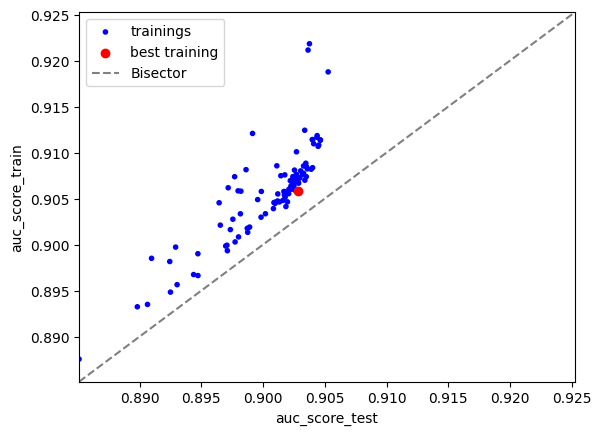

0.9028696806811172 0.9058236064496004


In [13]:
if onlyone:
    colors = ['blue'] * len(auc_score_testV)
    plt.scatter(auc_score_testV, auc_score_trainV, color=colors, marker='.', label='trainings')
    plt.scatter(auc_score_testV[best_trial_index], auc_score_trainV[best_trial_index], color='red', marker='o', label='best training')
    
    min_val = min(min(auc_score_testV), min(auc_score_trainV))
    max_val = max(max(auc_score_testV), max(auc_score_trainV))
    plt.plot([min_val, max_val+0.01], [min_val, max_val+0.01], linestyle='--', color='gray', label='Bisector')
    
    plt.xlabel('auc_score_test')
    plt.ylabel('auc_score_train')
    
    plt.xlim(min(auc_score_testV), max(auc_score_testV)+0.02)  # Esempio di range per l'asse X
    plt.ylim(min(auc_score_testV), max(auc_score_testV)+0.02)  # Esempio di range per l'asse Y

    plt.legend()
    # Visualizzazione del plot
    plt.show()
    print(auc_score_testV[best_trial_index], auc_score_trainV[best_trial_index])
